In [1]:
import os
os.chdir('/home/berling/reduce_opto_response/')
import pandas as pd
import numpy as np
from RONs import ChR_dynamics
from RONs import LoadReducedOptogeneticNeurons
from neurostim.light_propagation_models import fiber_Foutz2012
from scipy.constants import h, c
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
from article_figures.article_plot_functions import plot_morphology_with_light, label_subplots_ABC

In [2]:
def simulate_single_cell(
    soma_fpath, cond_scale_fpath, node_data_fpath, comp_data_fpath,
    diameter_um, NA,
    temp_protocol,
    fiber_intensity_mWPERmm2
):
    
    x_soma, y_soma, z_soma = np.load(soma_fpath)
    fiber_power_mW = fiber_intensity_mWPERmm2 * (diameter_um*1e-3/2)**2 * np.pi    
    comp_data = np.load(comp_data_fpath)
    node_data = np.load(node_data_fpath)
    
    # define light flux over time and space
    def flux(x, y, z, x_fiber, y_fiber, fiber_power_mW):
    
        # shift light source 
        x_ = x - x_fiber
        y_ = y - y_fiber
        z_ = z
        # calc_intensity at position
        light_intensity_WPERcm2 = fiber_power_mW * 1e-3 * fiber_Foutz2012(x_, y_, z_, diameter_um, NA)
        E_photon = h * c / (595e-9)
        fluxes_photonsPERcm2_fs = light_intensity_WPERcm2 / E_photon * 1e-15 # light_energy/s / photon_energy * 1e-15(fs conversion)
        times = np.arange(0,temp_protocol['total_rec_time_ms'],temp_protocol['interpol_dt_ms'])
        on = np.zeros(shape=times.shape)
        on[int(temp_protocol['delay_ms']/temp_protocol['interpol_dt_ms']):int(
            (temp_protocol['delay_ms']+temp_protocol['duration_ms'])/temp_protocol['interpol_dt_ms'])
           ] = 1
        fluxes_photonsPERcm2_fs = [flux * on for flux in fluxes_photonsPERcm2_fs]
        return np.array(fluxes_photonsPERcm2_fs)
    
    def manipulate_comp_data_on_copy(comp_data, node_data, z_thresh):
        """
        Turn off compartments with z larger z_thresh
        """
        manipulated_comp_data = comp_data.copy()
        comps_zselection = (node_data[:,:,2]>z_thresh).flatten()
        manipulated_comp_data[0, comps_zselection, :, 3] = False
        return manipulated_comp_data
        
    def manipulate_comp_data_on_copy_upper_tree(comp_data, node_data, z_thresh):
        """
        Turn off compartments with z larger z_thresh
        """
        manipulated_comp_data = comp_data.copy()
        comps_zselection = (node_data[:,:,2]<z_thresh).flatten()
        manipulated_comp_data[0, comps_zselection, :, 3] = False
        return manipulated_comp_data
        
    def deactivate_all_except_closest_comp_to_soma(comp_data, node_data):
        """
        Turn off compartments with z larger z_thresh
        """
        manipulated_comp_data = comp_data.copy()
        # calc radius from 0
        R = np.sqrt(node_data[0,:,0]**2 + node_data[0,:,1]**2 + node_data[0,:,2]**2)
        np.save('soma_comp_coords.npy', node_data[0,R==R.min(),:])
        manipulated_comp_data[0, R!=R.min(),:,3] = False
        return manipulated_comp_data
    def simulate_cond(fiber_positions, morph_condition, node_data, comp_data, fiber_power_mW):
        if morph_condition == 'point':
            # manipulate comp_data
            np.save(
                'manipulated_comp_data.npy',
                deactivate_all_except_closest_comp_to_soma(
                    comp_data,
                    node_data
                )
            )    
        elif morph_condition == 'full':
            # manipulate comp_data
            np.save(
                'manipulated_comp_data.npy',
                comp_data
            )
        elif morph_condition == 'bas.':
            # manipulate comp_data
            np.save(
                'manipulated_comp_data.npy',
                manipulate_comp_data_on_copy(
                    comp_data,
                    node_data,
                    z_thresh=100
                )
            )
        elif morph_condition == 'api.':
            # manipulate comp_data
            np.save(
                'manipulated_comp_data.npy',
                manipulate_comp_data_on_copy_upper_tree(
                    comp_data,
                    node_data,
                    z_thresh=100
                )
            )
            
        else: 
            raise ValueError()
        
        point_neuron_positions = np.array([
            [x_soma-x_fiber for (x_fiber, y_fiber) in fiber_positions],
            [y_soma-y_fiber for (x_fiber, y_fiber) in fiber_positions],
            [z_soma         for (x_fiber, y_fiber) in fiber_positions]
        ])
        # load reduced neuron:
        RONs = LoadReducedOptogeneticNeurons(
                    point_neuron_positions=point_neuron_positions, # point neurons soma coordinates
                    rotation_angles=np.array([0]), # random rotations of the morphology in radian
                    neuron_cond_scale_path=cond_scale_fpath,
                    neuron_node_data_path=node_data_fpath, # where to load "node data" of neuron morphologies
                    neuron_comp_data_path='manipulated_comp_data.npy'  # where to load "comp data" of neuron morphologies
                )
        RONs.calc_light_fluxes(
                func_xyz_to_flux=flux,
                func_args=dict(x_fiber=0, y_fiber=0, fiber_power_mW=fiber_power_mW)
        )
        # init ChR
        ChR_model = ChR_dynamics()
        # calculate effective optogenetic somatic conductance
        RONs.calc_effective_somatic_ChR_conductance(
            func_flux_to_conductance=ChR_model.calculate,
            func_args=dict(update_interval=temp_protocol['interpol_dt_ms'])
        )
        return RONs.conductance_nS_over_time
    
    radii = np.arange(25,325,25)
    thetas = np.linspace(0,2*np.pi,20)
    x_fiber = [0] + [R * np.sin(theta) for R in radii for theta in thetas]
    y_fiber = [0] + [R * np.cos(theta) for R in radii for theta in thetas]
    radii = [0] + [R for R in radii for theta in thetas]
    fiber_positions = list(zip(x_fiber,y_fiber))
    all_data = []
    cond_over_time_center = dict()
    conditions = ['full', 'bas.', 'api.', 'point']
    assert temp_protocol['interpol_dt_ms'] == 1, "Must be 1 otherwise calculation of t50 fails as index 100 is used to split array before 100 ms"
    times = np.arange(0, temp_protocol['total_rec_time_ms'], temp_protocol['interpol_dt_ms'])
    for condition in conditions:
        res=simulate_cond(
            fiber_positions=fiber_positions, 
            morph_condition=condition,
            node_data=node_data, comp_data=comp_data,
            fiber_power_mW=fiber_power_mW
        )
        # latency of rise to 50% of max
        t50 = times[np.argmin(np.abs(res[:,:100]-(res[:,:100].max(axis=1)/2)[:,np.newaxis]),axis=1)]
        cond_over_time_center[condition] = res[0]
        for r, s, l, t in zip(radii,res.sum(axis=1),res[:,20], t50):
            all_data.append({'r':r, 'summ':s, 'l20ms':l, 't50':t, 'condition':condition})
    df = pd.DataFrame(all_data).groupby(['r','condition']).mean().reset_index()
    df['summ_normed'] = df['summ'] / df.groupby('condition')['summ'].transform('max')
    df['l20ms_normed'] = df['l20ms'] / df.groupby('condition')['l20ms'].transform('max')
    return conditions, times, df, cond_over_time_center

def plot_all(conditions, times, df, cond_over_time_center):
    fig, axs = plt.subplots(ncols=2, nrows=2)
    axs = axs.flatten()
    for condition, ls in zip(conditions, ['solid','dotted','dashed','dashdot']):
        axs[0].plot(df.loc[df['condition']==condition].r, df.loc[df['condition']==condition].summ, label=condition, alpha=0.8, ls=ls)
        axs[0].legend()
        axs[1].plot(df.loc[df['condition']==condition].r, df.loc[df['condition']==condition].l20ms, label=condition, alpha=0.8, ls=ls)
        axs[1].legend()
        axs[2].plot(df.loc[df['condition']==condition].r, df.loc[df['condition']==condition].summ_normed, label=condition, alpha=0.8, ls=ls)
        axs[2].legend()
        axs[3].plot(df.loc[df['condition']==condition].r, df.loc[df['condition']==condition].l20ms_normed, label=condition, alpha=0.8, ls=ls)
        axs[3].legend()
    fig.show()

    fig = plt.figure()
    for condition, ls in zip(conditions, ['solid','dotted','dashed','dashdot']):
        plt.plot(df.loc[df['condition']==condition].r, df.loc[df['condition']==condition].t50, label=condition, alpha=0.8, ls=ls)
        plt.legend()
    fig.show()
        
    fig, axs = plt.subplots(ncols=2)
    for condition in conditions:
        axs[0].plot(times, cond_over_time_center[condition], label=condition)
        axs[1].plot(times, cond_over_time_center[condition]/cond_over_time_center[condition].max(), label=condition)
    axs[1].legend()
    fig.show()
    return None

def plot_integrated_conductance(ax, conditions, df, linestyles, colors):
    for condition, ls, c in zip(conditions, linestyles, colors):
        # axs[0].plot(df.loc[df['condition']==condition].r, df.loc[df['condition']==condition].summ, label=condition, alpha=0.8, ls=ls)
        # axs[1].plot(df.loc[df['condition']==condition].r, df.loc[df['condition']==condition].l20ms, label=condition, alpha=0.8, ls=ls)
        ax.plot(df.loc[df['condition']==condition].r, df.loc[df['condition']==condition].summ_normed, label=condition, alpha=0.8, ls=ls, color=c)
        # axs[3].plot(df.loc[df['condition']==condition].r, df.loc[df['condition']==condition].l20ms_normed, label=condition, alpha=0.8, ls=ls)
    return ax
    
def plot_latency(ax, conditions, df, linestyles, colors):
    for condition, ls, c in zip(conditions, linestyles, colors):
        ax.plot(df.loc[df['condition']==condition].r, df.loc[df['condition']==condition].t50, label=condition, alpha=0.8, ls=ls, color=c)
    return ax

def plot_cond_profile(ax, conditions, times, cond_over_time_center, hatch):
    for condition in conditions:
        ax.plot(times, cond_over_time_center[condition]/cond_over_time_center[condition].max(), label=condition, color='black', lw=0.5)
        if hatch:
            ax.fill_between(times, cond_over_time_center[condition]/cond_over_time_center[condition].max(), alpha=0.3, color='none', edgecolor='black', hatch='//')
    return ax

def rm_spines(ax, top_right_bottom_left = [1,1,0,0], ticks=True):
    for where, rm in zip(['top','right','bottom','left'], top_right_bottom_left):
        if rm:
            ax.spines[where].set_visible(False)
    if top_right_bottom_left[2] and ticks:
      ax.set_xticks([])
    if top_right_bottom_left[3] and ticks:
      ax.set_yticks([])

RON channel cond calculated.
RON channel cond calculated.
RON channel cond calculated.
RON channel cond calculated.


--No graphics will be displayed.



              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.6.0
 Built: Jan  9 2025 17:16:28

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.

Ca_HVA: gbar_Ca_HVA_somatic = 374.0 uS/cm^2, e_Ca_HVA = 132.4579341637009 mV
Ca_HVA: gbar_Ca_HVA_axonal = 306.0 uS/cm^2, e_Ca_HVA = 132.4579341637009 mV
Ca_HVA: gbar_Ca_HVA_basal = None uS/cm^2, e_Ca_HVA = 132.4579341637009 mV
Ca_HVA: gbar_Ca_HVA_apical = None uS/cm^2, e_Ca_HVA = 132.4579341637009 mV
Ca_LVAst: gbar_Ca_LVAst_somatic = 778.0 uS/cm^2, e_Ca_LVAst = 132.4579341637009 mV
Ca_LVAst: gbar_Ca_LVAst_axonal = 50.0 uS/cm^2, e_Ca_LVAst = 132.4579341637009 mV
Ca_LVAst: gbar_Ca_LVAst_basal = None uS/cm^2, e_Ca_LVAst = 132.4579341637009 mV
Ca_LVAst: gbar_Ca_LVAst_apical = None uS/cm^2, e_Ca_LVAst = 132.4579341637009 mV
Ih: gbar_Ih_somatic = 80.0 uS/cm^2, e_Ih = 

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


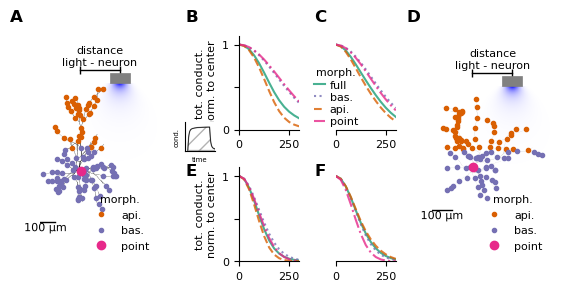

In [3]:
figure_name = 'article_figures/figures/article_figure5_wo_latency.png'
# 0.2 mW/mm2 corresponds to 0.0016 mW fiber output power for a 100 um diameter-fiber
fiber_intensity_mWPERmm2 = 0.2 # was 0.5 # was 1 

fontsize = 8
insetfontsize = 5
plt.rcParams.update({
    'font.size': fontsize,        # Set font size to 8
    'font.family': 'sans-serif'
    #'font.family': 'Arial'  # Set font to Arial
})
colors = ["#1b9e77", "#7570b3", "#d95f02", "#e7298a"]
linestyles = ['solid','dotted','dashed','dashdot']

# figure format
a4_w = 8.27
a4_l = 11.7
fig = plt.figure(figsize=(a4_w*0.8, a4_l*0.25))
gs = gridspec.GridSpec(2, 5, figure=fig, wspace=0.5, width_ratios = [2,0.1,1,1,2],height_ratios=[1, 1], hspace=0.4)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[0, 2])
ax4 = fig.add_subplot(gs[0, 3])
axd2 = fig.add_subplot(gs[1, 2])
axd4 = fig.add_subplot(gs[1, 3])
ax6 = fig.add_subplot(gs[:, 4])

ax2inset = fig.add_axes([ax2.get_position().x0-ax2.get_position().width*0.9, 
                         ax2.get_position().y0-ax2.get_position().height*0.22, 
                         ax2.get_position().width*0.5, 
                         ax2.get_position().height*0.3])

for ax in [ax2inset]:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(True)
    ax.set_xlim(-25,250)
    ax.set_ylim(0,1.2)
    ax.set_ylabel('cond.', fontsize=insetfontsize)
    ax.set_xlabel('time', fontsize=insetfontsize)

# Simulate data ########################################################################### cell 1 - divergent fiber
diameter_um = 100
NA = 0.9
# simulate conductances
node_data_fpath = 'snake_workflow/simulated_data/RON/L23_PC_cADpyr229_1-cluster_50-cond_scl_0.15-_node_data.npy'
conditions, times, df, cond_over_time_center = simulate_single_cell(
    soma_fpath = 'snake_workflow/simulated_data/RON/L23_PC_cADpyr229_1-cluster_50-cond_scl_0.15-soma_location.npy',
    cond_scale_fpath = 'snake_workflow/simulated_data/RON/L23_PC_cADpyr229_1-cluster_50-cond_scl_0.15-_cond_scale.npy',
    node_data_fpath = node_data_fpath,
    comp_data_fpath = 'snake_workflow/simulated_data/RON/L23_PC_cADpyr229_1-cluster_50-cond_scl_0.15-_comp_data.npy',
    diameter_um=diameter_um, 
    NA=NA,
    temp_protocol=dict(
        duration_ms = 200,
        delay_ms = 1,
        total_rec_time_ms=250,
        interpol_dt_ms = 1),
    fiber_intensity_mWPERmm2=fiber_intensity_mWPERmm2
)

# load cell morphology data 
from neurostim.analysis import quick_sim_setup
# Define cell and stimulator
simcontrol = quick_sim_setup(
    cell_dict = dict(
        cellmodel="L23_PC_cADpyr229_1",
        ChR_soma_density=13e9,
        ChR_distribution='uniform'),
    stimulator_dict = dict(
        diameter_um=diameter_um,
        NA=NA),
)
# calculate light profile
soma_depth = 423.3559875488281 # copy from printed info at cell initialization
n=2000
xs = np.linspace(-600,600, n)
zs = np.linspace(0,-800, n)
xx, zz = np.meshgrid(xs, zs)
I = simcontrol.stimulator.calculate_Tx_at_pos(pos_xyz_um=[xx,np.zeros(xx.shape),zz], stim_xyz_um=[0,0,0])

########################################################################################### Plot
ax1, light_prof_mappable = plot_morphology_with_light(
    ax=ax1, 
    simtree=simcontrol.cell.sim_tree, 
    marklocs=[],#[{'node': 1, 'x': 0.50 }], 
    locargs=[],#[dict(marker='o', mec='black', mfc='black')],
    morph_lw=0.5,
    light_prof_xx_zz_I=[xx+200,zz+soma_depth,I], 
    inset=False,
    sb_width=1.
)
# plot compartments on top
node_data = np.load(node_data_fpath)[0]
xyz_zl100 = node_data[node_data[:,2]>100]
xyz_zs100 = node_data[node_data[:,2]<100]
xyz_soma = np.load('soma_comp_coords.npy')
ax1.plot(xyz_zl100[:,0], xyz_zl100[:,2], c=colors[conditions.index('api.')], ls='', marker='.', label='api.')
ax1.plot(xyz_zs100[:,0], xyz_zs100[:,2], c=colors[conditions.index('bas.')], ls='', marker='.', label='bas.')
ax1.plot(xyz_soma[:,0], xyz_soma[:,2], c=colors[conditions.index('point')], ls='', marker='o', label='point')
ax1.set_xlim(-200, 400)

ax2.set_ylabel('tot. conduct.\nnorm. to center')
axd2.set_ylabel('tot. conduct.\nnorm. to center')
ax2.set_xlim(0,300)
ax2.set_ylim(0,1.1)
ax2.set_yticks([0,0.5,1])
ax2.set_yticklabels(['0','','1'])
# ax3.set_xlabel('light - neuron\ndistance [µm]')
# ax3.set_ylabel('latency (t50) [ms]')
# ax3.set_xlim(0,300)

plot_integrated_conductance(ax2, conditions, df, linestyles, colors)
#plot_latency(ax3, conditions, df, linestyles, colors)
plot_cond_profile(ax2inset, conditions=['full'], times=times, cond_over_time_center=cond_over_time_center, hatch=True)
#plot_cond_profile(ax3inset, conditions=['full'], times=times, cond_over_time_center=cond_over_time_center, hatch=False)
#t50_full_center = df.loc[(df.r==0) & (df.condition=='full')]['t50'].values[0]
#ax3inset.axvline(t50_full_center, color='black', lw=0.5)
#ax3inset.axhline(1, color='gray', ls='dashed', lw=0.5)
#ax3inset.axhline(0.5, color='gray', ls='dashed', lw=0.5)
# Add labels next to the lines
#ax3inset.text(ax3inset.get_xlim()[1], 1, "100%", verticalalignment='bottom', horizontalalignment='right', fontsize=insetfontsize, color='gray')
#ax3inset.text(ax3inset.get_xlim()[1], 0.5, "50%", verticalalignment='bottom', horizontalalignment='right', fontsize=insetfontsize, color='gray')
#ax3inset.text(t50_full_center, ax3inset.get_ylim()[1], "t50", verticalalignment='bottom', horizontalalignment='left', fontsize=insetfontsize)

for ax in [ax1]:
    rm_spines(ax, top_right_bottom_left=[1,1,1,1])
for ax in [ax2, ax2inset]:
    rm_spines(ax)
ax1.legend(title='morph.', frameon=False, loc='lower right')

#add fiber illustration:
rect = patches.Rectangle((150, soma_depth), 100, 50, linewidth=0.5, edgecolor='gray', facecolor='gray', transform=ax1.transData)
fig.add_artist(rect)
ax1.plot([0, 200], [soma_depth+65,soma_depth+65], c='black', marker="|", lw=1)
ax1.text(100, soma_depth+80, 'distance\nlight - neuron', ha='center', va='bottom', color='black')

# Simulate data ########################################################################### cell 2 - divergent fiber
diameter_um = 100
NA = 0.9
# simulate conductances
node_data_fpath = 'snake_workflow/simulated_data/RON/L23_PC_cADpyr229_3-cluster_50-cond_scl_0.15-_node_data.npy'
conditions, times, df, cond_over_time_center = simulate_single_cell(
    soma_fpath = 'snake_workflow/simulated_data/RON/L23_PC_cADpyr229_3-cluster_50-cond_scl_0.15-soma_location.npy',
    cond_scale_fpath = 'snake_workflow/simulated_data/RON/L23_PC_cADpyr229_3-cluster_50-cond_scl_0.15-_cond_scale.npy',
    node_data_fpath = node_data_fpath,
    comp_data_fpath = 'snake_workflow/simulated_data/RON/L23_PC_cADpyr229_3-cluster_50-cond_scl_0.15-_comp_data.npy',
    diameter_um=diameter_um, 
    NA=NA,
    temp_protocol=dict(
        duration_ms = 200,
        delay_ms = 1,
        total_rec_time_ms=250,
        interpol_dt_ms = 1),
    fiber_intensity_mWPERmm2=fiber_intensity_mWPERmm2
)

# load cell morphology data 
from neurostim.analysis import quick_sim_setup
# Define cell and stimulator
simcontrol = quick_sim_setup(
    cell_dict = dict(
        cellmodel="L23_PC_cADpyr229_3_without_mod_loading",
        ChR_soma_density=13e9,
        ChR_distribution='uniform'),
    stimulator_dict = dict(
        diameter_um=diameter_um,
        NA=NA),
)
# calculate light profile
soma_depth = 423.3559875488281 # copy from printed info at cell initialization
n=2000
xs = np.linspace(-600,600, n)
zs = np.linspace(0,-800, n)
xx, zz = np.meshgrid(xs, zs)
I = simcontrol.stimulator.calculate_Tx_at_pos(pos_xyz_um=[xx,np.zeros(xx.shape),zz], stim_xyz_um=[0,0,0])
########################################################################################### Plot
ax6, light_prof_mappable = plot_morphology_with_light(
    ax=ax6, 
    simtree=simcontrol.cell.sim_tree, 
    marklocs=[],#[{'node': 1, 'x': 0.50 }], 
    locargs=[],#[dict(marker='o', mec='black', mfc='black')],
    morph_lw=0.5,
    light_prof_xx_zz_I=[xx+200,zz+soma_depth,I], 
    inset=False,
    sb_width=1.
)
# plot compartments on top
node_data = np.load(node_data_fpath)[0]
xyz_zl100 = node_data[node_data[:,2]>100]
xyz_zs100 = node_data[node_data[:,2]<100]
xyz_soma = np.load('soma_comp_coords.npy')
ax6.plot(xyz_zl100[:,0], xyz_zl100[:,2], c=colors[conditions.index('api.')], ls='', marker='.', label='api.')
ax6.plot(xyz_zs100[:,0], xyz_zs100[:,2], c=colors[conditions.index('bas.')], ls='', marker='.', label='bas.')
ax6.plot(xyz_soma[:,0], xyz_soma[:,2], c=colors[conditions.index('point')], ls='', marker='o', label='point')
ax6.set_xlim(-200, 400)

ax4.set_xlim(0,300)
ax4.set_ylim(0,1.1)
ax4.set_yticks([0,0.5,1])
ax4.set_yticklabels(['0','','1'])
#ax5.set_xlabel('light - neuron\ndistance [µm]')
#ax5.set_xlim(0,300)

plot_integrated_conductance(ax4, conditions, df, linestyles, colors)
#plot_latency(ax5, conditions, df, linestyles, colors)

for ax in [ax6]:
    rm_spines(ax, top_right_bottom_left=[1,1,1,1])
for ax in [ax4]:
    rm_spines(ax, top_right_bottom_left=[1,1,0,1])

#ax4.legend(title='morph.', frameon=False, loc=(-0.52, 0.0))
ax6.legend(title='morph.', frameon=False, loc='lower right')

#add fiber illustration:
rect = patches.Rectangle((150, soma_depth), 100, 50, linewidth=0.5, edgecolor='gray', facecolor='gray', transform=ax6.transData)
fig.add_artist(rect)
ax6.plot([0, 200], [soma_depth+65,soma_depth+65], c='black', marker="|", lw=1)
ax6.text(100, soma_depth+80, 'distance\nlight - neuron', ha='center', va='bottom', color='black')


# Simulate data ########################################################################### cell 1 - precise fiber
diameter_um = 100
NA = 0.39
# simulate conductances
node_data_fpath = 'snake_workflow/simulated_data/RON/L23_PC_cADpyr229_1-cluster_50-cond_scl_0.15-_node_data.npy'
conditions, times, df, cond_over_time_center = simulate_single_cell(
    soma_fpath = 'snake_workflow/simulated_data/RON/L23_PC_cADpyr229_1-cluster_50-cond_scl_0.15-soma_location.npy',
    cond_scale_fpath = 'snake_workflow/simulated_data/RON/L23_PC_cADpyr229_1-cluster_50-cond_scl_0.15-_cond_scale.npy',
    node_data_fpath = node_data_fpath,
    comp_data_fpath = 'snake_workflow/simulated_data/RON/L23_PC_cADpyr229_1-cluster_50-cond_scl_0.15-_comp_data.npy',
    diameter_um=diameter_um, 
    NA=NA,
    temp_protocol=dict(
        duration_ms = 200,
        delay_ms = 1,
        total_rec_time_ms=250,
        interpol_dt_ms = 1),
    fiber_intensity_mWPERmm2=fiber_intensity_mWPERmm2
)

# load cell morphology data 
from neurostim.analysis import quick_sim_setup
# Define cell and stimulator
simcontrol = quick_sim_setup(
    cell_dict = dict(
        cellmodel="L23_PC_cADpyr229_1_without_mod_loading",
        ChR_soma_density=13e9,
        ChR_distribution='uniform'),
    stimulator_dict = dict(
        diameter_um=diameter_um,
        NA=NA),
)
# calculate light profile
soma_depth = 423.3559875488281 # copy from printed info at cell initialization
n=2000
xs = np.linspace(-600,600, n)
zs = np.linspace(0,-800, n)
xx, zz = np.meshgrid(xs, zs)
I = simcontrol.stimulator.calculate_Tx_at_pos(pos_xyz_um=[xx,np.zeros(xx.shape),zz], stim_xyz_um=[0,0,0])

########################################################################################### Plot
# axd1, light_prof_mappable = plot_morphology_with_light(
#     ax=axd1, 
#     simtree=simcontrol.cell.sim_tree, 
#     marklocs=[],#[{'node': 1, 'x': 0.50 }], 
#     locargs=[],#[dict(marker='o', mec='black', mfc='black')],
#     morph_lw=0.5,
#     light_prof_xx_zz_I=[xx+200,zz+soma_depth,I], 
#     inset=False,
#     sb_width=1.
# )
# # plot compartments on top
# node_data = np.load(node_data_fpath)[0]
# xyz_zl100 = node_data[node_data[:,2]>100]
# xyz_zs100 = node_data[node_data[:,2]<100]
# xyz_soma = np.load('soma_comp_coords.npy')
# axd1.plot(xyz_zl100[:,0], xyz_zl100[:,2], c=colors[conditions.index('api.')], ls='', marker='.', label='api.')
# axd1.plot(xyz_zs100[:,0], xyz_zs100[:,2], c=colors[conditions.index('bas.')], ls='', marker='.', label='bas.')
# axd1.plot(xyz_soma[:,0], xyz_soma[:,2], c=colors[conditions.index('point')], ls='', marker='o', label='point')
# axd1.set_xlim(-200, 400)

#axd2.set_ylabel('total conductance\nnormalized to center')
axd2.set_xlim(0,300)
axd2.set_ylim(0,1.1)
axd2.set_yticks([0,0.5,1])
axd2.set_yticklabels(['0','','1'])
# axd3.set_xlabel('light - neuron\ndistance [µm]')
# axd3.set_ylabel('latency (t50) [ms]')
# axd3.set_xlim(0,300)

plot_integrated_conductance(axd2, conditions, df, linestyles, colors)
# plot_latency(axd3, conditions, df, linestyles, colors)
#plot_cond_profile(ax2, conditions=['full'], times=times, cond_over_time_center=cond_over_time_center, hatch=True)
#plot_cond_profile(ax4, conditions=['full'], times=times, cond_over_time_center=cond_over_time_center, hatch=False)
# t50_full_center = df.loc[(df.r==0) & (df.condition=='full')]['t50'].values[0]
#ax4.axvline(t50_full_center, color='black', lw=0.5)
#ax4.axhline(1, color='gray', ls='dashed', lw=0.5)
#ax4.axhline(0.5, color='gray', ls='dashed', lw=0.5)
# Add labels next to the lines
#ax4.text(ax4.get_xlim()[1], 1, "100%", verticalalignment='bottom', horizontalalignment='right', fontsize=fontsize, color='gray')
#ax4.text(ax4.get_xlim()[1], 0.5, "50%", verticalalignment='bottom', horizontalalignment='right', fontsize=fontsize, color='gray')
#ax4.text(t50_full_center, ax4.get_ylim()[1], "t50", verticalalignment='bottom', horizontalalignment='left', fontsize=fontsize)

# for ax in [axd1]:
#     rm_spines(ax, top_right_bottom_left=[1,1,1,1])
for ax in [axd2]:
    rm_spines(ax)
# axd1.legend(title='morph.', frameon=False, loc='lower right')

#add fiber illustration:
# rect = patches.Rectangle((150, soma_depth), 100, 50, linewidth=0.5, edgecolor='gray', facecolor='gray', transform=axd1.transData)
# fig.add_artist(rect)
# axd1.plot([0, 200], [soma_depth+65,soma_depth+65], c='black', marker="|", lw=1)
# axd1.text(100, soma_depth+80, 'distance\nlight - neuron', ha='center', va='bottom', color='black')

# Simulate data ########################################################################### cell 2 - precise fiber
diameter_um = 100
NA = 0.39
# simulate conductances
node_data_fpath = 'snake_workflow/simulated_data/RON/L23_PC_cADpyr229_3-cluster_50-cond_scl_0.15-_node_data.npy'
conditions, times, df, cond_over_time_center = simulate_single_cell(
    soma_fpath = 'snake_workflow/simulated_data/RON/L23_PC_cADpyr229_3-cluster_50-cond_scl_0.15-soma_location.npy',
    cond_scale_fpath = 'snake_workflow/simulated_data/RON/L23_PC_cADpyr229_3-cluster_50-cond_scl_0.15-_cond_scale.npy',
    node_data_fpath = node_data_fpath,
    comp_data_fpath = 'snake_workflow/simulated_data/RON/L23_PC_cADpyr229_3-cluster_50-cond_scl_0.15-_comp_data.npy',
    diameter_um=diameter_um, 
    NA=NA,
    temp_protocol=dict(
        duration_ms = 200,
        delay_ms = 1,
        total_rec_time_ms=250,
        interpol_dt_ms = 1),
    fiber_intensity_mWPERmm2=fiber_intensity_mWPERmm2
)

# load cell morphology data 
from neurostim.analysis import quick_sim_setup
# Define cell and stimulator
simcontrol = quick_sim_setup(
    cell_dict = dict(
        cellmodel="L23_PC_cADpyr229_3_without_mod_loading",
        ChR_soma_density=13e9,
        ChR_distribution='uniform'),
    stimulator_dict = dict(
        diameter_um=diameter_um,
        NA=NA),
)
# calculate light profile
soma_depth = 423.3559875488281 # copy from printed info at cell initialization
n=2000
xs = np.linspace(-600,600, n)
zs = np.linspace(0,-800, n)
xx, zz = np.meshgrid(xs, zs)
I = simcontrol.stimulator.calculate_Tx_at_pos(pos_xyz_um=[xx,np.zeros(xx.shape),zz], stim_xyz_um=[0,0,0])
########################################################################################### Plot
# axd6, light_prof_mappable = plot_morphology_with_light(
#     ax=axd6, 
#     simtree=simcontrol.cell.sim_tree, 
#     marklocs=[],#[{'node': 1, 'x': 0.50 }], 
#     locargs=[],#[dict(marker='o', mec='black', mfc='black')],
#     morph_lw=0.5,
#     light_prof_xx_zz_I=[xx+200,zz+soma_depth,I], 
#     inset=False,
#     sb_width=1.
# )
# plot compartments on top
# node_data = np.load(node_data_fpath)[0]
# xyz_zl100 = node_data[node_data[:,2]>100]
# xyz_zs100 = node_data[node_data[:,2]<100]
# xyz_soma = np.load('soma_comp_coords.npy')
# axd6.plot(xyz_zl100[:,0], xyz_zl100[:,2], c=colors[conditions.index('api.')], ls='', marker='.', label='api.')
# axd6.plot(xyz_zs100[:,0], xyz_zs100[:,2], c=colors[conditions.index('bas.')], ls='', marker='.', label='bas.')
# axd6.plot(xyz_soma[:,0], xyz_soma[:,2], c=colors[conditions.index('point')], ls='', marker='o', label='point')
# axd6.set_xlim(-200, 400)

axd4.set_xlim(0,300)
axd4.set_ylim(0,1.1)
axd4.set_yticks([0,0.5,1])
axd4.set_yticklabels(['0','','1'])
# axd5.set_xlabel('light - neuron\ndistance [µm]')
# axd5.set_xlim(0,300)

plot_integrated_conductance(axd4, conditions, df, linestyles, colors)
# plot_latency(axd5, conditions, df, linestyles, colors)

# for ax in [axd6]:
    # rm_spines(ax, top_right_bottom_left=[1,1,1,1])
for ax in [axd4]:
    rm_spines(ax, top_right_bottom_left=[1,1,0,1])
# axd6.legend(title='morph.', frameon=False, loc='lower right')

#add fiber illustration:
# rect = patches.Rectangle((150, soma_depth), 100, 50, linewidth=0.5, edgecolor='gray', facecolor='gray', transform=axd6.transData)
# fig.add_artist(rect)
# axd6.plot([0, 200], [soma_depth+65,soma_depth+65], c='black', marker="|", lw=1)
# axd6.text(100, soma_depth+80, 'distance\nlight - neuron', ha='center', va='bottom', color='black')
ax4.legend(title='morph.', 
           frameon=False, 
           loc=(-.4, 0.01),
           borderpad=0.2,        # padding between legend content and border
           labelspacing=0.2,     # vertical space between labels
           handlelength=1.,     # length of the legend line
           handletextpad=0.4
)

fig.text(0.08, 0.93, 'A', fontsize=12, weight='bold')
fig.text(0.345, 0.93, 'B', fontsize=12, weight='bold')
fig.text(0.54, 0.93, 'C', fontsize=12, weight='bold')
fig.text(0.345, 0.405, 'E', fontsize=12, weight='bold')
fig.text(0.54, 0.405, 'F', fontsize=12, weight='bold')
fig.text(0.68, 0.93, 'D', fontsize=12, weight='bold')


fig.savefig(figure_name, dpi=600)
fig.show()

Text(0.68, 0.97, 'D')

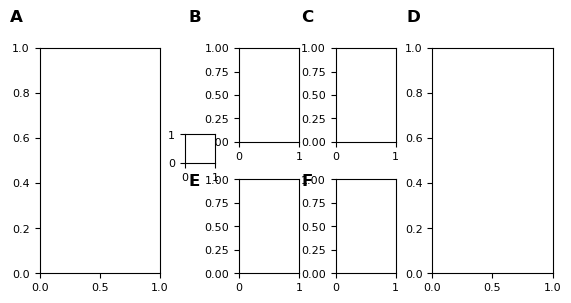

In [4]:
a4_w = 8.27
a4_l = 11.7
fig = plt.figure(figsize=(a4_w*0.8, a4_l*0.25))
gs = gridspec.GridSpec(2, 5, figure=fig, wspace=0.5, width_ratios = [2,0.1,1,1,2],height_ratios=[1, 1], hspace=0.4)
ax0 = fig.add_subplot(gs[:, 0])
ax1 = fig.add_subplot(gs[0, 2])
ax2 = fig.add_subplot(gs[0, 3])
ax3 = fig.add_subplot(gs[1, 2])
ax4 = fig.add_subplot(gs[1, 3])
ax5 = fig.add_subplot(gs[:, 4])

ax1inset = fig.add_axes([ax1.get_position().x0-ax1.get_position().width*0.9, 
                         ax1.get_position().y0-ax1.get_position().height*0.22, 
                         ax1.get_position().width*0.5, 
                         ax1.get_position().height*0.3])

fig.text(0.08, 0.97, 'A', fontsize=12, weight='bold')
fig.text(0.35, 0.97, 'B', fontsize=12, weight='bold')
fig.text(0.52, 0.97, 'C', fontsize=12, weight='bold')
fig.text(0.35, 0.41, 'E', fontsize=12, weight='bold')
fig.text(0.52, 0.41, 'F', fontsize=12, weight='bold')
fig.text(0.68, 0.97, 'D', fontsize=12, weight='bold')
